In [45]:
from preprocessing_copy import preprocess_pipeline
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [46]:
# 이상치 데이터 평가
anomaly_file_path = "이상치데이터예제.csv"
seq_length = 3

In [47]:
# 저장된 모델 로드
autoencoder = load_model('autoencoder_model2.h5')

In [48]:
# 데이터 전처리
X_anomaly = preprocess_pipeline(anomaly_file_path, seq_length)

In [49]:
# 정상 데이터 로드 및 평가
X_normal = preprocess_pipeline("Dummy_01.csv", seq_length)
reconstructed_normal = autoencoder.predict(X_normal)
normal_reconstruction_errors = np.mean(np.abs(X_normal - reconstructed_normal), axis=(1, 2))

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step


In [50]:
# 모델 평가
reconstructed = autoencoder.predict(X_anomaly)
reconstruction_errors = np.mean(np.abs(X_anomaly - reconstructed), axis=(1, 2))  # MSE → MAE 적용
print("Reconstruction errors calculated.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
Reconstruction errors calculated.


In [51]:
# 정상 데이터 기반 threshold 설정 (3σ 적용)
threshold = np.mean(normal_reconstruction_errors) + 3 * np.std(normal_reconstruction_errors)

In [52]:
# epc_code별 이상치 개수 분석
anomalies = reconstruction_errors > threshold
df_anomaly = pd.read_csv(anomaly_file_path)
df_anomaly = df_anomaly.iloc[-len(X_anomaly):]  # 테스트 데이터에 해당하는 부분만 선택
df_anomaly["reconstruction_error"] = reconstruction_errors
df_anomaly["anomaly"] = anomalies

Number of anomalies detected: 119
epc_code
001.8805843.584374.000000009    10
001.8805843.584374.000000010    10
001.8805843.584374.000000011    10
001.8805843.584374.000000012    10
001.8805843.584374.000000013    10
001.8805843.584374.000000014    10
001.8805843.584374.000000015    10
001.8805843.584374.000000016    10
001.8805843.584374.000000017    10
001.8805843.584374.000000018    10
001.8805843.584374.000000019    10
001.8805843.584374.000000020     9
Name: anomaly, dtype: int64
이상치 포함 epc_code 비율: 100.00%


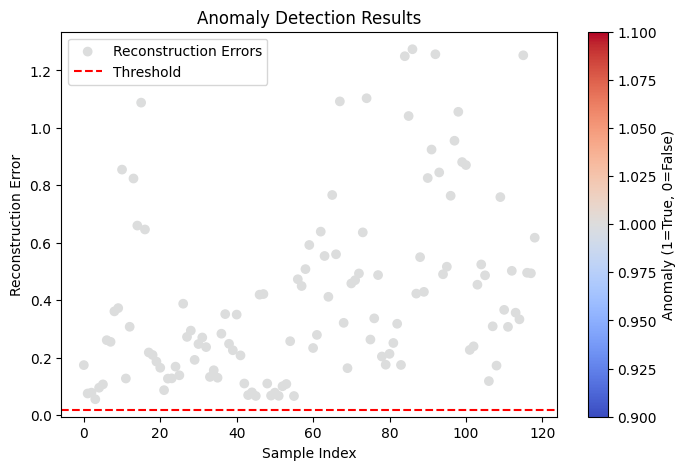

In [55]:
# 이상치 탐지
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# epc_code별 이상치 개수 집계
epc_anomaly_counts = df_anomaly.groupby("epc_code")["anomaly"].sum()

# 이상치가 1개 이상인 epc_code만 출력
print(epc_anomaly_counts[epc_anomaly_counts > 1])

# epc_code별 이상치 포함 비율 출력
total_epc_codes = df_anomaly["epc_code"].nunique()
anomaly_epc_codes = epc_anomaly_counts[epc_anomaly_counts > 1].count()
print(f"이상치 포함 epc_code 비율: {anomaly_epc_codes / total_epc_codes:.2%}")

plt.figure(figsize=(8, 5))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=anomalies, cmap="coolwarm", label="Reconstruction Errors")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.colorbar(label="Anomaly (1=True, 0=False)")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Anomaly Detection Results")
plt.legend()
plt.show()


In [54]:
# # 이상치 탐지
# threshold = np.mean(reconstruction_errors) + np.std(reconstruction_errors)
# anomalies = reconstruction_errors > threshold
# print(f"Number of anomalies detected: {np.sum(anomalies)}")

# anomaly_indices = np.where(anomalies)[0]
# print(f"Reconstruction errors for detected anomalies:\n{anomalies}")

# plt.figure(figsize=(8, 5))
# plt.hist(reconstruction_errors, bins=50, alpha=0.7, label="All Data")
# plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
# plt.title("Reconstruction Error Distribution")
# plt.xlabel("Reconstruction Error")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()